Cell 1: Setup, Library Installation, and Data Loading

In [ ]:
# Cell 1: Setup, Library Installation, and Data Loading

import json
import re
from collections import Counter, defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

# Load the case file data
file_path = 'murder_mystery.json'
try:
    with open(file_path, 'r') as f:
        case_data = json.load(f)
    data_loaded_successfully = True
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found. Please ensure it's in the correct directory.")
    data_loaded_successfully = False
except json.JSONDecodeError:
    print(f"Error: The file {file_path} is not a valid JSON file.")
    data_loaded_successfully = False

if data_loaded_successfully:
    murderer_note_text = case_data['metadata']['victim_note']
    interrogations = case_data['interrogations']
    all_guest_names = sorted(list(set([inter['guest'] for inter in interrogations]))) # Get all unique guest names

    print("--- Data Loaded Successfully ---")
    print(f"Murderer's Note (Victim's Note field): {murderer_note_text[:100]}...")
    print(f"Number of interrogations: {len(interrogations)}")
    print(f"List of all guests: {all_guest_names}")
else:
    print("Halting execution due to data loading errors.")

c:\Users\Alina\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Data Loaded Successfully ---
Murderer's Note (Victim's Note field): Och, Yer carefully constructed life is built on foundations of sand, and the tide is coming in. I ha...
Number of interrogations: 59
List of all guests: ['Ambassador Beaumont', 'Ambassador Gold', 'Ambassador Indigo', 'Ambassador Northbrook', 'Ambassador Peacock', 'Ambassador Umber', 'Archbishop Coral', 'Archbishop Whitmore', 'Baron Blackwood', 'Baron Brown', 'Baron Nightingale', 'Baron Sienna', 'Baron Whitehall', 'Barrister Beaumont', 'Barrister Peacock', 'Brigadier Black', 'Chancellor Harrington', 'Colonel Ravenswood', 'Commodore Ebony', 'Commodore White', 'Counselor Montgomery', 'Counselor Scarlett', 'Count Silver', 'Countess Grimshaw', 'Dean Stonehaven', 'Doctor Ashcroft', 'Doctor Grimshaw', 'Doctor Scarlett', 'Duchess Cunningham', 'Duchess Ravenswood', 'Duchess Summerville', 'Earl Pearl', 'General White', 'Inspector Ivory', 'Inspector Ravenscroft', 'Judge Winthrop', 'Lady Crimson', 'Lord Green', 'Madame Northbr

We will use semantic similarity (via SBERT) to compare witness statements with the content of the note in order to identify the suspect.

Cell 2: Step 1 - Semantic Similarity (SBERT)

In [2]:
# Cell 2: Step 1 - Semantic Similarity (SBERT)

if data_loaded_successfully and sbert_available:
    print("\n--- Step 1: Semantic Similarity (SBERT) ---")
    # Load a pre-trained SBERT model
    # 'all-MiniLM-L6-v2' is a good balance of speed and performance.
    # Other models: 'paraphrase-MiniLM-L6-v2', 'all-mpnet-base-v2' (slower, more accurate)
    try:
        model_name = 'all-MiniLM-L6-v2'
        sbert_model = SentenceTransformer(model_name)
        print(f"SBERT model '{model_name}' loaded successfully.")

        # Embed the murderer's note
        note_embedding = sbert_model.encode(murderer_note_text, convert_to_tensor=True)
        print("Murderer's note embedded.")

        # Embed all interrogation statements
        statement_texts = [inter['statement'] for inter in interrogations]
        statement_embeddings = sbert_model.encode(statement_texts, convert_to_tensor=True)
        print(f"{len(statement_texts)} statements embedded.")

        # Calculate cosine similarity between the note and each statement
        similarities = []
        for i, stmt_embedding in enumerate(statement_embeddings):
            # Cosine similarity returns a tensor of tensors, get the single value
            similarity_score = util.pytorch_cos_sim(note_embedding, stmt_embedding).item()
            similarities.append({
                "guest": interrogations[i]['guest'],
                "similarity_to_note": similarity_score,
                "statement": statement_texts[i][:150] + "..."
            })

        # Sort by similarity
        sorted_similarities = sorted(similarities, key=lambda x: x['similarity_to_note'], reverse=True)

        print("\n--- Top Statements by Semantic Similarity to Murderer's Note ---")
        for item in sorted_similarities[:5]: # Display top 5
            print(f"Guest: {item['guest']}, Similarity: {item['similarity_to_note']:.4f}")
            # print(f"  Statement: {item['statement']}")
        
        # Store for later use if needed
        sbert_results = sorted_similarities

    except Exception as e:
        print(f"An error occurred during SBERT processing: {e}")
        print("This might be due to model download issues or an incompatible environment.")
        sbert_available = False # Disable further SBERT-dependent steps
else:
    print("\n--- Step 1: Semantic Similarity (SBERT) SKIPPED (due to missing library or data loading error) ---")


--- Step 1: Semantic Similarity (SBERT) ---
SBERT model 'all-MiniLM-L6-v2' loaded successfully.
Murderer's note embedded.
59 statements embedded.

--- Top Statements by Semantic Similarity to Murderer's Note ---
Guest: Doctor Ashcroft, Similarity: 0.4041
Guest: Viscount Pemberton, Similarity: 0.3964
Guest: Baron Sienna, Similarity: 0.3910
Guest: Lord Green, Similarity: 0.3614
Guest: Inspector Ivory, Similarity: 0.3374


Let's examine the murderer's note to identify distinctive dialect words or phrases that may serve as linguistic markers.

Cell 3: Step 2 – Define Dialect Markers from the Murderer's Note

In [ ]:
# Cell 3: Step 2 - Define Dialect Markers from the Murderer's Note

# Based on this, potential dialect markers (converted to lowercase for matching):
# These are words that strongly suggest a Scottish or similar dialect.
dialect_markers_from_note = [
    "och", "yer", "hae", "wi'", "thocht", "telt", "aboot", "tae", "throo", "ye"
]

print("--- Key Dialect Markers from the Victim's Note (Murderer's Note) ---")
print(dialect_markers_from_note)

# Function to analyze text for dialect markers
def analyze_dialect(text, markers):
    """
    Analyzes a given text for the presence and frequency of dialect markers.
    Returns a count of unique markers found and a list of all markers found (for frequency).
    """
    text_lower = text.lower()
    # Use regex to find whole words to avoid partial matches (e.g., 'a' in 'have')
    # and handle contractions like 'wi''
    words_in_text = re.findall(r"\b\w+'?\w*\b", text_lower)

    found_markers_list = []
    for marker in markers:
        for word in words_in_text:
            if word == marker:
                found_markers_list.append(marker)

    unique_found_markers = sorted(list(set(found_markers_list)))

    # Score is the total number of occurrences of the dialect markers
    score = len(found_markers_list)

    return score, unique_found_markers, found_markers_list

# Test the function with the victim's note itself
note_score, note_unique_markers, note_all_markers = analyze_dialect(murderer_note_text, dialect_markers_from_note)
print(f"\n--- Analysis of Victim's Note Dialect ---")
print(f"Dialect Score (total occurrences): {note_score}")
print(f"Unique dialect markers found: {note_unique_markers}")
print(f"Frequency of all dialect markers: {Counter(note_all_markers)}")

--- Key Dialect Markers from the Victim's Note (Murderer's Note) ---
['och', 'yer', 'hae', "wi'", 'thocht', 'telt', 'aboot', 'tae', 'throo', 'ye']

--- Analysis of Victim's Note Dialect ---
Dialect Score (total occurrences): 15
Unique dialect markers found: ['aboot', 'hae', 'och', 'tae', 'telt', 'thocht', 'throo', 'ye', 'yer']
Frequency of all dialect markers: Counter({'yer': 5, 'aboot': 2, 'ye': 2, 'och': 1, 'hae': 1, 'thocht': 1, 'telt': 1, 'tae': 1, 'throo': 1})


We will analyze the suspects' statements to check for the presence of the same dialect markers found in the murderer's note.

Cell 4: Step 3 – Analyze Suspects' Statements for Dialect Match

In [ ]:
# Cell 4: Step 3 – Analyze Suspects' Statements for Dialect Match

suspect_dialect_scores = []

print("\n--- Analyzing Suspect Statements for Dialect Matches ---")
for interview in interrogations:
    guest_name = interview['guest']
    statement = interview['statement']
    
    score, unique_markers, all_found_markers = analyze_dialect(statement, dialect_markers_from_note)
    
    if score > 0: # Only record suspects with at least one marker
        suspect_dialect_scores.append({
            "guest": guest_name,
            "score": score,
            "unique_markers_found": sorted(list(unique_markers)),
            "all_markers_found (frequency)": Counter(all_found_markers),
        })

# Sort suspects by score in descending order
sorted_suspects_by_dialect = sorted(suspect_dialect_scores, key=lambda x: x['score'], reverse=True)

print("\n--- Suspects Ranked by Dialect Match Score (Higher is More Similar) ---")
if not sorted_suspects_by_dialect:
    print("No suspects found with significant dialect markers matching the note.")
else:
    for suspect in sorted_suspects_by_dialect:
        print(f"\nGuest: {suspect['guest']}")
        print(f"  Score: {suspect['score']}")
        print(f"  Unique Markers Found: {suspect['unique_markers_found']}")
        print(f"  All Markers (Frequency): {suspect['all_markers_found (frequency)']}")


--- Analyzing Suspect Statements for Dialect Matches ---

--- Suspects Ranked by Dialect Match Score (Higher is More Similar) ---

Guest: Baron Sienna
  Score: 14
  Unique Markers Found: ['aboot', 'hae', 'tae', 'ye']
  All Markers (Frequency): Counter({'aboot': 10, 'tae': 2, 'hae': 1, 'ye': 1})

Guest: Counselor Montgomery
  Score: 12
  Unique Markers Found: ['aboot', 'hae', 'tae', 'ye']
  All Markers (Frequency): Counter({'aboot': 8, 'tae': 2, 'hae': 1, 'ye': 1})

Guest: Inspector Ivory
  Score: 10
  Unique Markers Found: ['aboot', 'hae', 'ye']
  All Markers (Frequency): Counter({'aboot': 8, 'hae': 1, 'ye': 1})

Guest: Viscount Pemberton
  Score: 8
  Unique Markers Found: ['aboot', 'ye']
  All Markers (Frequency): Counter({'aboot': 6, 'ye': 2})

Guest: Viscount Onyx
  Score: 8
  Unique Markers Found: ['aboot', 'tae', 'ye']
  All Markers (Frequency): Counter({'aboot': 5, 'tae': 2, 'ye': 1})

Guest: Brigadier Black
  Score: 7
  Unique Markers Found: ['aboot', 'tae', 'ye']
  All Markers

We will cluster the suspects' statements based on semantic similarity to uncover patterns or groupings that may reveal shared narratives or coordinated lies.

Cell 5: Step 4 – Clustering Interrogations

In [ ]:
# Cell 5: Step 4 - Clustering Interrogations

if data_loaded_successfully and sbert_available and sklearn_available: # Depends on SBERT embeddings
    print("\n--- Step 2: Clustering Interrogations based on Semantic Content ---")
    
    # We use the statement_embeddings from the SBERT step
    # Convert embeddings to a NumPy array if they aren't already
    if not isinstance(statement_embeddings, np.ndarray):
        embeddings_for_clustering = statement_embeddings.cpu().numpy() # Move to CPU and convert
    else:
        embeddings_for_clustering = statement_embeddings

    # Determine a reasonable number of clusters
    # This can be heuristic. For 60 guests, maybe 7-8 clusters..
    num_clusters = 7
    if len(embeddings_for_clustering) < num_clusters:
        num_clusters = max(1, len(embeddings_for_clustering)) # Ensure num_clusters is not too large
        print(f"Warning: Number of statements is less than desired clusters. Adjusting clusters to {num_clusters}")

    if num_clusters > 0 and embeddings_for_clustering.shape[0] >= num_clusters:
        try:
            kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
            cluster_labels = kmeans.fit_predict(embeddings_for_clustering)

            # Group statements by cluster
            clustered_statements = {i: [] for i in range(num_clusters)}
            for i, label in enumerate(cluster_labels):
                clustered_statements[label].append({
                    "guest": interrogations[i]['guest'],
                    "statement": interrogations[i]['statement'][:100] + "..."
                })

            print(f"\n--- Statements Grouped into {num_clusters} Clusters ---")
            for cluster_id, members in clustered_statements.items():
                print(f"\nCluster {cluster_id + 1}: ({len(members)} members)")
                for member in members:
                    print(f"  - {member['guest']}: {member['statement']}")
        except Exception as e:
            print(f"An error occurred during clustering: {e}")

    elif num_clusters == 0:
        print("Cannot perform clustering with zero clusters.")
    else:
        print("Not enough data points to form the specified number of clusters.")

else:
    print("\n--- Step 4: Clustering Interrogations SKIPPED (due to missing libraries, data error, or SBERT failure) ---")


--- Step 2: Clustering Interrogations based on Semantic Content ---

--- Statements Grouped into 7 Clusters ---

Cluster 1: (4 members)
  - Ambassador Gold: I was definitely in the kitchen right at 11:50pm. I was admiring the artwork and trying to relax aft...
  - Mister Onyx: I was in the library late in the evening, smoking a pipe. It was a quiet evening, and I didn't expec...
  - Mister Coral: I was definitely in the kitchen at 11:50pm exactly. I was smoking a pipe and trying to relax after t...
  - Ambassador Peacock: I was in the conservatory just before midnight, playing cards. It was a quiet evening, and I didn't ...

Cluster 2: (21 members)
  - Ambassador Indigo: Well, I can tell you exactly where I was - in the conservatory, listening to music. I remember becau...
  - Baron Brown: Well, I can tell you exactly where I was - in the study, having a drink. I remember because I was th...
  - Commodore White: At that time, I was in the billiard room. I often go there in the evening

We will extract "who saw whom" relationships from the interrogations to begin constructing a network of interactions between individuals.

Cell 6: Step 5 - Network Analysis - Part A: Extracting "Who Saw Whom"

In [ ]:
# Cell 6: Step 5 - Network Analysis - Part A: Extracting "Who Saw Whom"

if data_loaded_successfully:
    print("\n--- Step 3: Network Analysis ---")
    print("--- Part A: Extracting 'Who Saw Whom' Relationships ---")

    # Normalize guest names for reliable matching.
    # Create a mapping from parts of names to full names.
    # E.g., "General Azure" -> "General Azure", "Azure" -> "General Azure"
    guest_name_map = {}
    for full_name in all_guest_names:
        guest_name_map[full_name.lower()] = full_name # Full name match
        parts = full_name.split()
        if len(parts) > 1:
            guest_name_map[parts[-1].lower()] = full_name # Last name match
            if len(parts) > 2: # e.g. "Doctor Van Der Beek"
                 guest_name_map[parts[0].lower() + " " + parts[-1].lower()] = full_name # Title + Last name

    # Store sightings: (Observer, Observed)
    sightings = []
    
    # The pattern looks for known guest names.
    # We build a dynamic regex pattern for all known guests.
    # Sort by length to match longer names first (e.g., "General Azure" before "Azure")
    sorted_guest_match_patterns = sorted(guest_name_map.keys(), key=len, reverse=True)
    # Escape special regex characters in names and ensure whole word matching
    guest_regex_pattern = r'\b(' + '|'.join(re.escape(name) for name in sorted_guest_match_patterns) + r')\b'


    for interview in interrogations:
        observer = interview['guest']
        statement_lower = interview['statement'].lower()
        
        # Find all mentions of other guests in the statement
        # This regex looks for names.
        mentioned_guests_in_statement = re.findall(guest_regex_pattern, statement_lower, flags=re.IGNORECASE)
        
        observed_people_normalized = set()
        for mentioned_name_part in mentioned_guests_in_statement:
            normalized_name = guest_name_map.get(mentioned_name_part.lower())
            if normalized_name and normalized_name != observer: # Ensure it's a valid guest and not self-sighting
                observed_people_normalized.add(normalized_name)
        
        for observed in observed_people_normalized:
            sightings.append((observer, observed))

    print(f"\nExtracted {len(sightings)} 'who saw whom' potential relationships.")
    if sightings:
        print("Sample sightings:")
        for s in sightings[:5]:
            print(f"  {s[0]} claims to have seen {s[1]}")
    else:
        print("No explicit 'saw whom' relationships extracted. Check name matching logic or statements.")
    
    # Store for next step
    extracted_sightings = sightings
else:
    print("\n--- Step 5: Network Analysis - Part A SKIPPED (due to data loading error) ---")


--- Step 3: Network Analysis ---
--- Part A: Extracting 'Who Saw Whom' Relationships ---

Extracted 1511 'who saw whom' potential relationships.
Sample sightings:
  Professor Blackstone claims to have seen Miss Azure
  Professor Blackstone claims to have seen Mister Fitzgerald
  Professor Blackstone claims to have seen Dean Stonehaven
  Professor Blackstone claims to have seen Major Whitmore
  Professor Blackstone claims to have seen Ambassador Gold


We will build and visualize the social network based on the extracted interactions to reveal connections, clusters, and potential inconsistencies.

Cell 7: Step 6 - Network Analysis - Part B: Building and Visualizing Social Network


--- Part B: Building and Visualizing Social Network ---


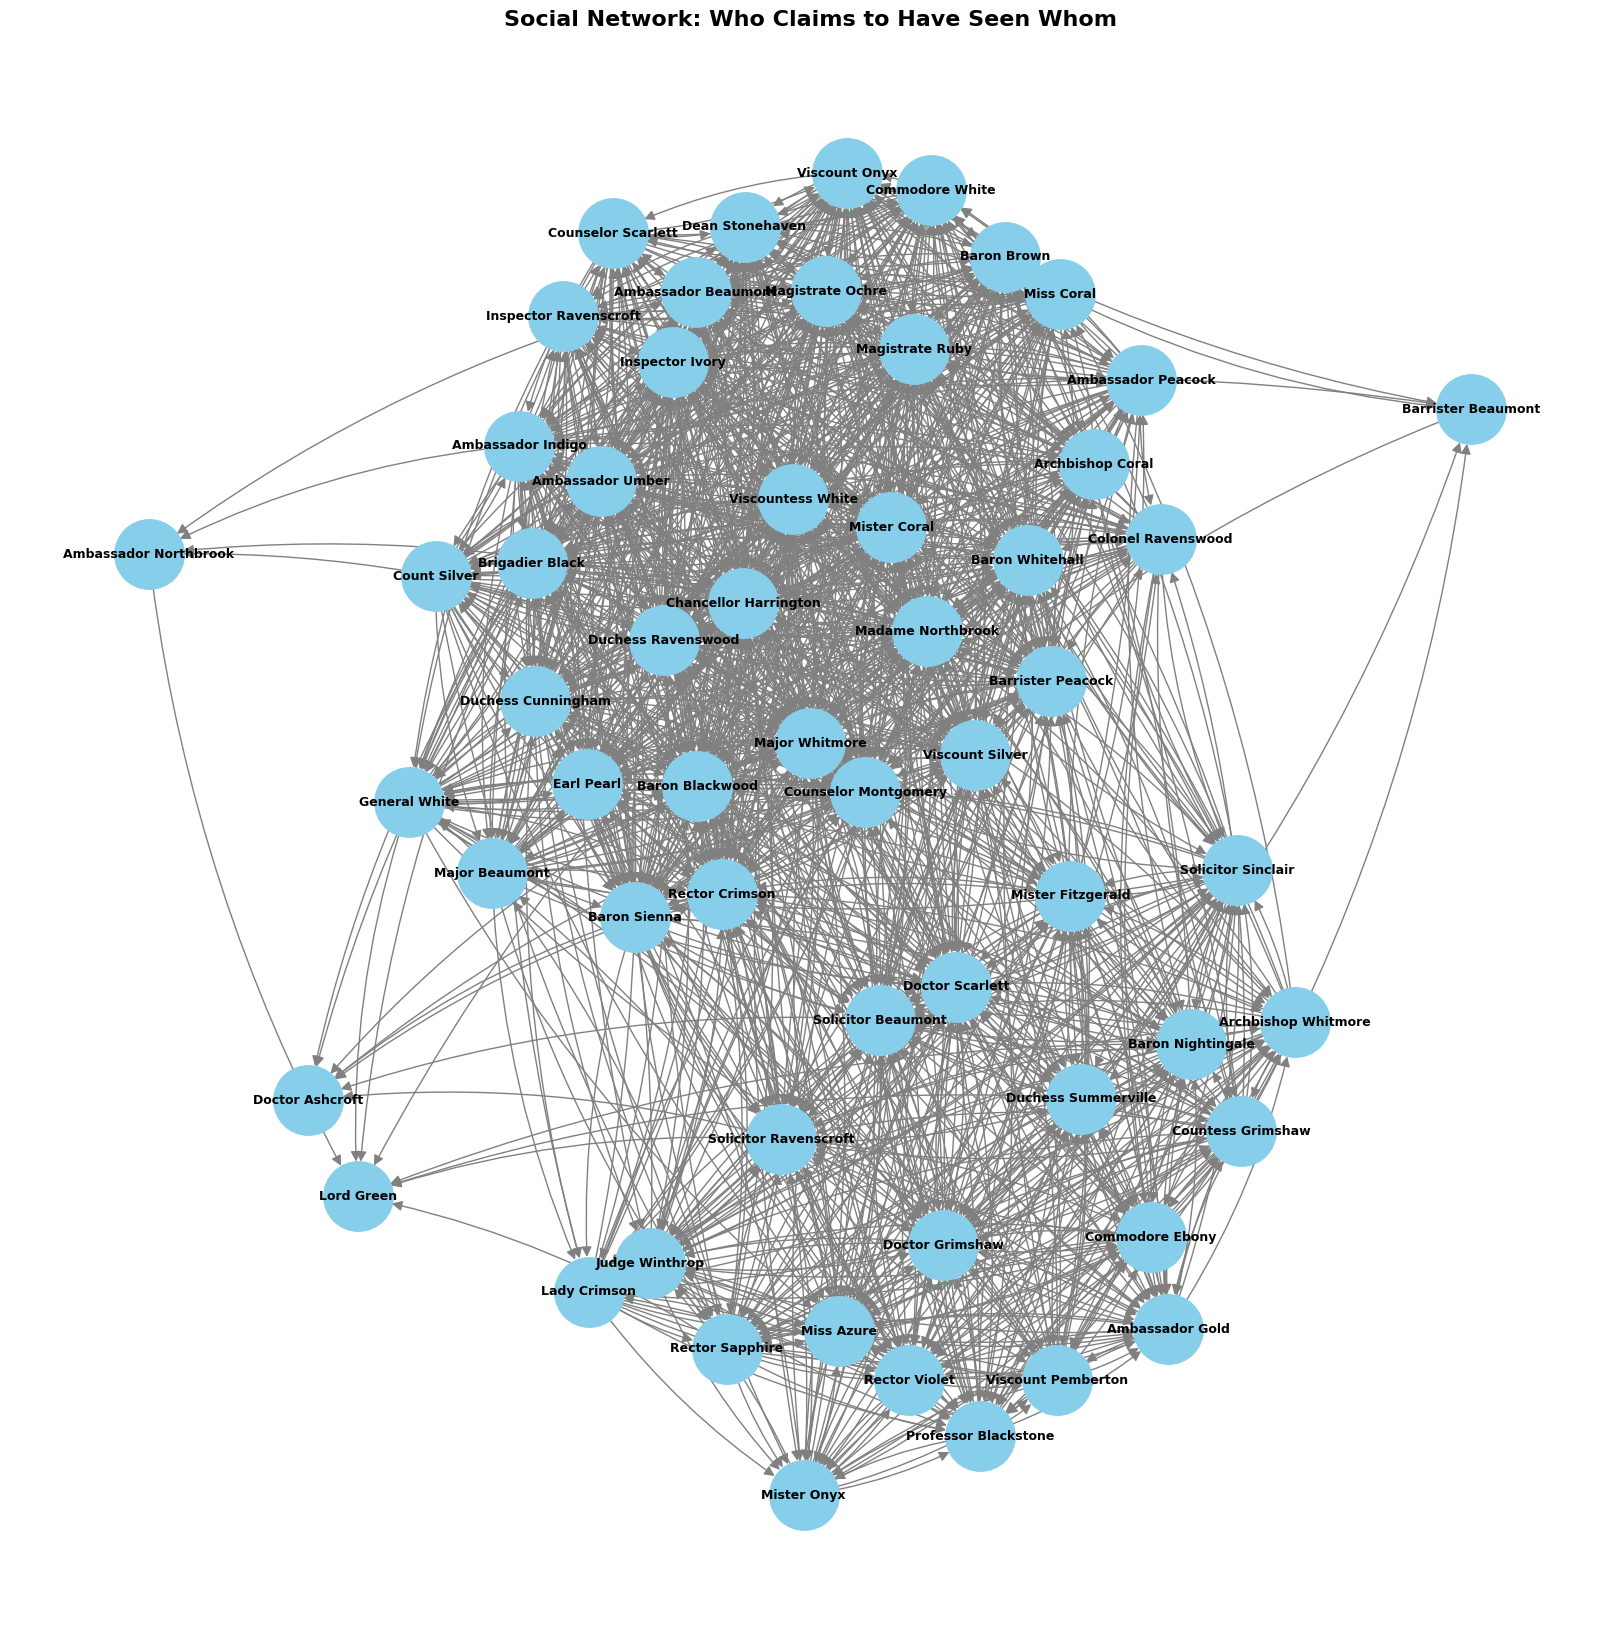


--- Detailed Network Statistics ---
Number of guests (nodes): 59
Number of reported sightings (edges): 1511

--- Guests Ranked by How Frequently They Were Seen ---
  1. Major Whitmore: Seen by 42 other(s)
  2. Rector Crimson: Seen by 41 other(s)
  3. Baron Blackwood: Seen by 41 other(s)
  4. Solicitor Beaumont: Seen by 39 other(s)
  5. Duchess Ravenswood: Seen by 39 other(s)
  6. Viscountess White: Seen by 38 other(s)
  7. Doctor Scarlett: Seen by 38 other(s)
  8. Counselor Montgomery: Seen by 38 other(s)
  9. Chancellor Harrington: Seen by 38 other(s)
  10. Barrister Peacock: Seen by 38 other(s)
  11. Viscount Silver: Seen by 37 other(s)
  12. Mister Coral: Seen by 37 other(s)
  13. Madame Northbrook: Seen by 35 other(s)
  14. Ambassador Umber: Seen by 35 other(s)
  15. Baron Sienna: Seen by 34 other(s)
  16. Magistrate Ruby: Seen by 33 other(s)
  17. Magistrate Ochre: Seen by 33 other(s)
  18. Duchess Cunningham: Seen by 33 other(s)
  19. Viscount Onyx: Seen by 32 other(s)
  20. Ear

In [ ]:
# Cell 7: Step 6 - Network Analysis - Part B: Building and Visualizing Social Network

if data_loaded_successfully and networkx_available and 'extracted_sightings' in locals() and extracted_sightings:
    print("\n--- Part B: Building and Visualizing Social Network ---")
    
    G = nx.DiGraph() # Directed graph as "A saw B" is not necessarily "B saw A"
    
    # Add all guests as nodes to ensure even those not involved in sightings are plotted
    for guest in all_guest_names:
        G.add_node(guest)
        
    # Add edges for sightings
    for observer, observed in extracted_sightings:
        if G.has_node(observer) and G.has_node(observed):
             G.add_edge(observer, observed)
        else:
            print(f"Warning: Could not add edge ({observer} -> {observed}) due to missing node(s). Check name normalization.")


    if G.number_of_edges() > 0:
        plt.figure(figsize=(16, 16)) # Increased figure size
        pos = nx.kamada_kawai_layout(G) # kamada_kawai_layout often gives good separation

        nx.draw(G, pos, with_labels=True, node_size=2500, node_color="skyblue", 
                font_size=9, font_weight="bold", arrows=True, arrowstyle='-|>', 
                arrowsize=15, width=1.0, edge_color="gray",
                connectionstyle='arc3,rad=0.1') # Added connectionstyle for curved edges
        
        plt.title("Social Network: Who Claims to Have Seen Whom", size=16, fontweight='bold')
        plt.show()
        
        # --- Network Statistics ---
        print("\n--- Detailed Network Statistics ---")
        print(f"Number of guests (nodes): {G.number_of_nodes()}")
        print(f"Number of reported sightings (edges): {G.number_of_edges()}")

        # In-degree: how many people reported seeing a particular guest
        in_degrees = G.in_degree()
        # Sort by count (degree[1]), then by name (degree[0]) for consistent ordering
        sorted_in_degrees = sorted(in_degrees, key=lambda x: (x[1], x[0]), reverse=True) 
        
        print("\n--- Guests Ranked by How Frequently They Were Seen ---")
        if sorted_in_degrees:
            for i, (guest, count) in enumerate(sorted_in_degrees):
                # Only print if count > 0, or print all if you want to see everyone including those not seen
                if count > 0: 
                    print(f"  {i+1}. {guest}: Seen by {count} other(s)")
                else: # Show those not seen
                     print(f"  {i+1}. {guest}: Seen by 0 others") 
            if not any(count > 0 for _, count in sorted_in_degrees):
                 print("  No guests were reported as seen by others.")
        else:
            print("  Could not calculate in-degrees.")
        
        # Out-degree: how many people a particular guest reported seeing
        out_degrees = G.out_degree()
        # Sort by count (degree[1]), then by name (degree[0]) for consistent ordering
        sorted_out_degrees = sorted(out_degrees, key=lambda x: (x[1], x[0]), reverse=True)
        
        print("\n--- Guests Ranked by How Many People They Reported Seeing ---")
        if sorted_out_degrees:
            for i, (guest, count) in enumerate(sorted_out_degrees):
                # Only print if count > 0, or print all
                if count > 0:
                    print(f"  {i+1}. {guest}: Reported seeing {count} other(s)")
                else: # Show those who saw no one
                     print(f"  {i+1}. {guest}: Reported seeing 0 others")
            if not any(count > 0 for _, count in sorted_out_degrees):
                 print("  No guests reported seeing anyone.")
        else:
            print("  Could not calculate out-degrees.")

    else: # If G.number_of_edges() == 0
        print("No edges (sightings) were added to the graph. Cannot visualize or calculate detailed stats.")
        if not extracted_sightings:
            print("This is likely because no 'who saw whom' relationships were extracted in Part A.")
        # Print all guests even if no edges, to show they are in the system
        print("\nList of all guests considered (nodes):")
        for i, guest_node in enumerate(G.nodes()):
            print(f"  {i+1}. {guest_node}")


else: # Conditions for running this cell are not met
    if not data_loaded_successfully:
        print("\n--- Part B: Social Network Visualization SKIPPED (due to data loading error) ---")
    elif not networkx_available:
        print("\n--- Part B: Social Network Visualization SKIPPED (due to missing NetworkX/Matplotlib) ---")
    elif 'extracted_sightings' not in locals(): # Check if variable exists
        print("\n--- Part B: Social Network Visualization SKIPPED ('extracted_sightings' not defined from Part A) ---")
    elif not extracted_sightings: # Check if variable is empty
         print("\n--- Part B: Social Network Visualization SKIPPED (no sightings extracted in Part A, 'extracted_sightings' is empty) ---")

We will analyze the social network for contradictions or discrepancies in the reported interactions to identify potential lies or hidden connections.

Cell 8: Step 5 - Network Analysis - Part C & D: Contradictions/Discrepancies

In [14]:
# Cell 8: Step 5 - Network Analysis - Part C & D: Contradictions/Discrepancies

if data_loaded_successfully and 'extracted_sightings' in locals():
    print("\n--- Part C & D: Analyzing Contradictions/Discrepancies & Absences ---")

    potential_contradictions = []
    # Stores guests who explicitly claim they saw no one or were alone, and the evidence.
    claims_seeing_no_one_info = {} 

    # Expanded list of phrases indicating seeing no one / being alone (all lowercase)
    # This list aims to catch more nuanced expressions.
    negative_observation_phrases = [
        "saw no one", "was alone", "didn't see anyone", "did not see anyone",
        "recall seeing no one", "saw nobody", "didn't notice anyone", "did not notice anyone",
        "don't recall seeing anyone", "dinnae recall seeing anyone", "couldn't recall seeing anyone",
        "do not recall seeing anyone", "could not recall seeing anyone", "no i dinnae recall seeing anyone",
        "i was by myself", "there was no one else", "i saw no one there",
        "i can't recall seeing anyone", "cannot recall seeing anyone",
        "i don't remember seeing anyone", "i do not remember seeing anyone",
        "i didn't see a soul", "did not see a soul"
    ]

    for interview in interrogations:
        guest = interview['guest']
        statement_lower = interview['statement'].lower()
        
        # Sanitize statement for better matching by removing punctuation around keywords
        # This helps if a phrase is at the end of a sentence. e.g., "seeing anyone."
        # statement_for_search = re.sub(r'[^\w\s\']', '', statement_lower) # Removes most punctuation
        # A simpler approach for now is to ensure phrases are distinct enough or use \b in regex if needed

        for phrase in negative_observation_phrases:
            # Check for whole word/phrase matching to avoid partial matches
            # Using ' in ' is simple, but regex with \b (word boundaries) would be more robust
            # For example: \bphrase\b
            # For simplicity here, direct 'in' check is used, assuming phrases are distinct enough.
            if phrase in statement_lower:
                # Store the first matching phrase as evidence
                if guest not in claims_seeing_no_one_info: # Only take the first hit per guest
                    claims_seeing_no_one_info[guest] = {
                        "text_evidence": f"Matched phrase: '{phrase}' in statement.",
                    }

    print("\n--- Guests Claiming to See No One or Be Alone (Based on Expanded Phrase List) ---")
    if not claims_seeing_no_one_info:
        print("  No guests explicitly found claiming to see no one or be alone based on the current phrase list.")
    else:
        for guest, info in claims_seeing_no_one_info.items():
            print(f"\n  GUEST: {guest}")
            print(f"    Claim Evidence: {info['text_evidence']}")
            
            # Now, check for contradictions: Did anyone claim to see THIS guest?
            seen_by_others = [s_observer for s_observer, s_observed in extracted_sightings if s_observed == guest]
            if seen_by_others:
                contradiction_detail = (
                    f"POTENTIAL CONTRADICTION: {guest} claims to see no one/be alone (evidence: \"{info['text_evidence']}\"), "
                    f"but was reportedly seen by: {', '.join(sorted(list(set(seen_by_others))))}."
                )
                potential_contradictions.append(contradiction_detail)
                print(f"    ATTENTION: Reportedly seen by -> {', '.join(sorted(list(set(seen_by_others))))}")
            else:
                print(f"    Not reportedly seen by others (consistent with their claim so far).")

    # --- Mutual vs. One-Way Sightings (using the graph G if available) ---
    if networkx_available and 'G' in locals() and G.number_of_edges() > 0:
        print("\n\n--- Analyzing Mutual vs. One-Way Sightings ---")
        one_way_sightings_details = []
        mutual_sightings_pairs = set() # Stores tuples of (guest1, guest2) sorted alphabetically

        for u, v in G.edges(): # u claims to have seen v
            if G.has_edge(v, u): # v also claims to have seen u (mutual)
                pair = tuple(sorted((u, v)))
                if pair not in mutual_sightings_pairs:
                    mutual_sightings_pairs.add(pair)
            else: # u saw v, but v did not report seeing u (one-way)
                one_way_sightings_details.append(f"{u} reported seeing {v}, but {v} did not report seeing {u}.")
        
        if mutual_sightings_pairs:
            print("\n  Mutual Sightings (Pairs who reported seeing each other):")
            for pair in sorted(list(mutual_sightings_pairs)):
                print(f"    - {pair[0]} and {pair[1]}")
        else:
            print("\n  No mutual sightings found where both parties confirmed seeing each other.")

        if one_way_sightings_details:
            print("\n  One-Way Sightings (A saw B, but B didn't report seeing A):")
            # Sort for consistent output, and limit to a few examples if many
            for ows_detail in sorted(one_way_sightings_details)[:10]: 
                print(f"    - {ows_detail}")
        else:
            print("\n  No one-way sightings found (or all sightings were mutual).")
            
    elif not (networkx_available and 'G' in locals()):
         print("\nNetwork graph G not available, skipping mutual/one-way sighting analysis.")
    elif 'G' in locals() and G.number_of_edges() == 0:
         print("\nNetwork graph G has no edges, skipping mutual/one-way sighting analysis.")

else:
    print("\n--- Part C & D: Contradictions/Discrepancies SKIPPED (due to data/library issues or no sightings extracted) ---")



--- Part C & D: Analyzing Contradictions/Discrepancies & Absences ---

--- Guests Claiming to See No One or Be Alone (Based on Expanded Phrase List) ---

  GUEST: Lord Green
    Claim Evidence: Matched phrase: 'didn't notice anyone' in statement.
    ATTENTION: Reportedly seen by -> Ambassador Northbrook, Baron Nightingale, Brigadier Black, Duchess Summerville, General White, Mister Coral, Rector Sapphire, Solicitor Ravenscroft


--- Analyzing Mutual vs. One-Way Sightings ---

  Mutual Sightings (Pairs who reported seeing each other):
    - Ambassador Beaumont and Ambassador Indigo
    - Ambassador Beaumont and Ambassador Peacock
    - Ambassador Beaumont and Ambassador Umber
    - Ambassador Beaumont and Archbishop Coral
    - Ambassador Beaumont and Baron Blackwood
    - Ambassador Beaumont and Baron Brown
    - Ambassador Beaumont and Baron Whitehall
    - Ambassador Beaumont and Colonel Ravenswood
    - Ambassador Beaumont and Commodore White
    - Ambassador Beaumont and Counselo

We will extract and analyze words and phrases used by others when speaking about the main suspect to gain insight into their relationships, attitudes, and possible motives.

Cell 9: Step 6 – Words About the Main Suspect

In [ ]:
# Cell 9: Step 6 – Words About the Main Suspect

statements_about_ashcroft = []

# Iterate through each interrogation record
for inter in interrogations:
    # Check if 'Doctor Ashcroft' is in the statement (case-insensitive for better matching)
    if 'doctor ashcroft' in inter['statement'].lower():
        statements_about_ashcroft.append({
            'speaker': inter['guest'],  # Assuming 'guest' is the key for the speaker's name
            'statement': inter['statement']
        })

# Print the collected statements
print("\n--- What people said about Doctor Ashcroft ---")
if statements_about_ashcroft:
    for entry in statements_about_ashcroft:
        print(f"- {entry['speaker']}: \"{entry['statement']}\"")
else:
    print("No specific statements found about Doctor Ashcroft in the interrogations.")


--- What people said about Doctor Ashcroft ---
- Baron Blackwood: "Well, I can tell you exactly where I was - in the study, resting quietly. I remember because I was there from about 11:30pm until well after midnight. I was in conversation with Ambassador Umber about business matters, Montgomery was there with me, we were having a drink together, I was in conversation with Indigo about business matters, I was talking with Earl Pearl for quite some time, I spent most of the time chatting with Inspector Ravenscroft, Magistrate Ruby was there with me, we were having a drink together, Harrington was there with me, we were having a drink together, I was talking with Peacock for quite some time, I was in conversation with Mister Coral about business matters, Stonehaven and I were enjoying the evening together, I was playing cards with Silver, I was talking with Duchess Ravenswood for quite some time, I was playing cards with Madame Northbrook, Viscount Onyx was there with me, we were having